本章讲解图像之间的变换，以及一些计算变换的实用方法。

# 1. 单应性变换 (Homography)

*单应性变换* 是将一个平面内的点映射到另一个平面内的 **二维投影变换** 。直线在该变换下仍映射为直线。单应性变换可用于图像配准、图像纠正和图像扭曲，以及创建全景图像

### 齐次坐标下的单应性变换

在齐次坐标下，单应性变换按照下面的方程映射二维中的点：

$  \begin{bmatrix} x' \\ y' \\ w' \end{bmatrix} 
 = \begin{bmatrix} h_1 & h_2 & h_3 \\ 
                   h_4 & h_5 & h_6 \\ 
                   h_7 & h_8 & h_9 \end{bmatrix} 
   \begin{bmatrix} x \\ y \\ w \end{bmatrix} 
$ 或 $ \mathbf x' = \mathbf H \mathbf x $

齐次坐标 (homogeneous coordinates)* 是用于投影集合的坐标系统。点的齐次坐标依赖于其尺度定义，$ \mathbf x = [x,y,w] = [\alpha x, \alpha y, \alpha w] = [x/w, y/w, 1] $ 都表示同一个二维点。

因此，单应性矩阵 H 也依赖尺度定义，具有 8 个独立的自由度。通常使用 w = 1 来归一化点，这样，点具有唯一的图像坐标 x 和 y。

为什么不用笛卡尔坐标？
* 透视射影在笛卡儿坐标下不是线性变换。因为使用笛卡儿坐标，矩阵乘无法执行透视射影所必需的除法运算。

进行点和变换的处理时，按照 **列优先原则** 存储点。

### 线性变换

线性变换在几何上的三个要求：
* 变换前是直线，变换后仍是直线
* 直线上各处的比例不变
* 原点不变

线性变换通过矩阵乘法实现。其例子有旋转、错切（推移）、镜像（翻转）、伸缩。

### 仿射变换 (Affine transformation)

*仿射变换* 对一个向量空间进行一次线性变换并接上一个平移，将其变换为另一个向量空间。

仿射变换在几何上有两个要求，相对线性变换少了原点不变的要求：
* 变换前是直线，变换后仍是直线
* 直线上各处的比例不变

一个对向量 $ \vec {x} $ 平移 $\vec  {t} $ 和旋转缩放 A 的仿射映射为： 

$ {\vec  {x'}}=A{\vec  {x}}+{\vec  {t}} $ 

在齐次坐标下，其等价于：

$  \begin{bmatrix} x' \\ y' \\ 1 \end{bmatrix} 
 = \begin{bmatrix} a_1 & a_2 & t_x \\ 
                   a_3 & a_4 & t_y \\ 
                   0 & 0 & 1 \end{bmatrix} 
   \begin{bmatrix} x \\ y \\ 1 \end{bmatrix} 
$ 或 
$  \mathbf x' 
 = \begin{bmatrix} \mathbf A & \mathbf t \\ 
                   \mathbf 0 & 1 \end{bmatrix} 
    \mathbf x $
    
即增加了一个维度后，使用高维度的线性变换，完成了低维度的仿射变换。

仿射变换保持了 w = 1, 不具有投影变换所具有的强大变形能力。可用于图像扭曲。

### 相似变换

相似变换是一个包含尺度变化的二维刚体变换。

$  \begin{bmatrix} x' \\ y' \\ 1 \end{bmatrix} 
 = \begin{bmatrix} s cos(\theta) & -s sin(\theta) & t_x \\ 
                   s sin(\theta) & s cos(\theta) & t_y \\ 
                   x & y & 1 \end{bmatrix} 
   \begin{bmatrix} x \\ y \\ 1 \end{bmatrix} 
$ 或 
$  \mathbf x' 
 = \begin{bmatrix} s \mathbf R & \mathbf t \\ 
                   \mathbf 0 & 1 \end{bmatrix} 
    \mathbf x $
    
其中，s 指定了变换的尺度，$ \mathbf R $ 是角度为 $ \theta $ 的旋转矩阵，$ \mathbf t = [t_x, t_y] $ 是平移向量。当 s = 1 时，变换为刚体变换。


下面探讨如何设计用于估计单应性矩阵的算法，然后用仿射变换进行图像扭曲，用相似变换进行图像匹配，用完全投影变换创建全景图像。

## 直接线性变换算法：由对应点估计单应性矩阵

单应性矩阵可以由两幅图像中的对应点（通过上一章特征匹配得到）计算出来。一个完全射影变换有 8 个自由度。每个对应点可以写出两个方程，分别对应于 x 和 y 坐标。因此，计算单应性矩阵 H 需要 4 个对应点对。

*DLT (Direct Linear Transformation, 直接线性变换)* 是给定 4 个或者更多对应点对矩阵，来计算单应性矩阵的算法。其方程为：

$$ \begin{bmatrix}
    -x_1 & -y_1 & -1 & 0 & 0 & 0 & x_1 x'_1 & y_1 x'_1 & x'_1 \\
    0 & 0 & 0 & -x_1 & -y_1 & -1 & x_1 y'_1 & y_1 y'_1 & y'_1 \\
    -x_2 & -y_2 & -1 & 0 & 0 & 0 & x_2 x'_2 & y_2 x'_2 & x'_2 \\
     0 & 0 & 0 & -x_2 & -y_2 & -1 & x_2 y'_2 & y_2 y'_2 & y'_2 \\
    ...
   \end{bmatrix} \begin{bmatrix}
    h_1 \\ h_2 \\ h_3 \\ h_4 \\ h_5 \\ h_6 \\ h_7 \\ h_8 \\ h_9
   \end{bmatrix} 
 = \mathbf 0 
$$

或者 $\mathbf A \mathbf h = \mathbf 0$ . 

### DLT 的推导过程

记变换前后两幅图片中的特征匹配点分别为 $(x,y,1)$ 和 $(x',y',1)$，有：

$$ \begin{pmatrix} x' \\ y' \\ 1 \end{pmatrix}
  = \mathbf H \begin{pmatrix} x \\ y \\ 1 \end{pmatrix} 
  = \begin{bmatrix} h_1 & h_2 & h_3 \\ 
                    h_4 & h_5 & h_6 \\ 
                    h_7 & h_8 & h_9 \end{bmatrix} 
    \begin{pmatrix} x \\ y \\ 1 \end{pmatrix} $$

展开，前两行乘以第三行，得到：

$$ -h_1 x - h_2 y - h_3 + x' (h_7 x + h_8 y + h_9 ) = 0 $$

$$ -h_4 x - h_5 y - h_6 + y' (h_7 x + h_8 y + h_9 ) = 0 $$
   
整理为矩阵形式：

$$ A \mathbf h = 0 $$

其中

$$ A = \begin{pmatrix} 
           -x & -y & -1 & 0 & 0 & 0 & x x' & y x' & x' \\
           0 & 0 & 0 & -x & -y & -1 & x y' & y y' & y' 
        \end{pmatrix} $$
        
$$ \mathbf h = \begin{pmatrix} h_1 & h_2 & h_3 & h_4 & h_5 & h_6 & h_7 & h_8 & h_9 \end{pmatrix} ^ T$$

可以使用 SVD (Singular Value Decomposition，奇异值分解) 算法找到 H 的最小二乘解。

代码实现在 `tools.homography.H_from_points` .


## 仿射变换

仿射变换有 6 个自由度，需要 3 个对应点来估计矩阵 H 。 通过令 $ h_7 = h_8 = 0 $，仿射变换可以用上述 DLT 算法估计得出。

这里使用 *Multiple View Geometry in Computer Vision, ISBN: 0521540518* 中介绍的另一种方法计算单应性矩阵 H，实现在 `tools.homography.Haffine_from_points` .

# 2. 图像扭曲

对图像块应用仿射变换，称为 *图像扭曲* （或 *仿射扭曲* ）。

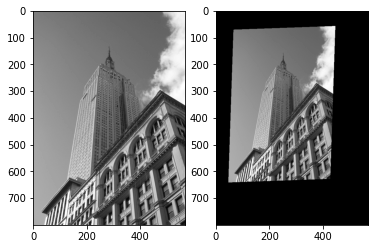

In [1]:
from PIL import Image
from numpy import *
from pylab import *
from scipy import ndimage

im = array(Image.open('data/empire.jpg').convert('L'))
H = array([[1.4, 0.05, -100], [0.05, 1.5, -100], [0, 0, 1]])
im2 = ndimage.affine_transform(im, H[:2, :2], (H[0,2], H[1,2]))

fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(im, cmap='gray')
ax[1].imshow(im2, cmap='gray')

## 图像中的图像

仿射扭曲的一个简单例子是，将图像或者图像的一部分放置在另一幅图像中，使得它们能够和指定的区域或者标记物对齐。

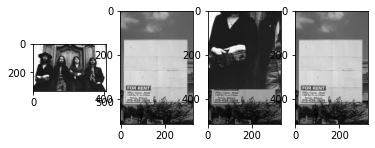

In [119]:
from tools import warp
from importlib import reload
reload(warp)

# 仿射扭曲 im1 到 im2 的例子
im1 = array(Image.open('data/beatles.jpg').convert('L'))
im2 = array(Image.open('data/billboard_for_rent.jpg').convert('L'))

# 选定一些目标 TODO
tp = array([[130, 315, 315, 130], [18, 18, 304, 304], [1, 1, 1, 1]])
im3 = warp.image_in_image(im1, im2, tp)
tp = array([[337, 414, 414, 337], [27, 26, 140, 140], [1, 1, 1, 1]])
im4 = warp.image_in_image(im1, im2, tp)

fig, ax = plt.subplots(nrows=1, ncols=4)
ax[0].imshow(im1, cmap='gray')
ax[1].imshow(im2, cmap='gray')
ax[2].imshow(im3, cmap='gray')
ax[3].imshow(im4, cmap='gray')

在具有很强透视效应的情况下，我们不可能使用同一个仿射变换将全部 4 个角点变换到它们的目标位置（尽管可以使用完全投影变换来完成该任务）。

一个有用的技巧是将图像分成三角形。对于 3 个点，仿射变换可以将一幅图像进行扭曲，使这 3 对对应点完美匹配。这是因为，仿射变换有 6 个自由度，3 对对应点可以给出 6 个约束条件。

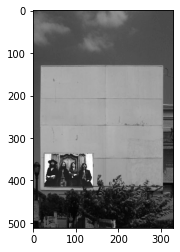

In [38]:
from mappings import homography

# 选定 im1 角上的一些点
m, n = im1.shape[:2]
fp = array([[0, m, m, 0], [0, 0, n, n], [1, 1, 1, 1]])

# 第一个三角形
tp2 = tp[:, :3]
fp2 = fp[:, :3]

# 计算 H
H = homography.Haffine_from_points(tp2, fp2)
im1_t = ndimage.affine_transform(im1, H[:2, :2],
                                (H[0,2], H[1,2]), im2.shape[:2])

# 三角形的 alpha
alpha = warp.alpha_for_triangle(tp2, im2.shape[0], im2.shape[1])
im3 = (1-alpha)*im2 + alpha*im1_t

# 第二个三角形
tp2 = tp[:, [0, 2, 3]]
fp2 = fp[:, [0, 2, 3]]

# 计算 H
H = homography.Haffine_from_points(tp2, fp2)
im1_t = ndimage.affine_transform(im1, H[:2, :2],
                                (H[0,2], H[1,2]), im2.shape[:2])

# 三角形的 alpha
alpha = warp.alpha_for_triangle(tp2, im2.shape[0], im2.shape[1])
im4 = (1-alpha)*im3 + alpha*im1_t

figure()
gray()
imshow(im4)
show()


## 分段仿射扭曲

*分段仿射扭曲*：给定任意图像的标记点，通过将这些点进行三角剖分，然后使用仿射扭曲来扭曲每个三角形。

为了三角化这些点，我们经常使用 *狄洛克三角剖分* 法，其使三角剖分中所有三角形的最小角度最大。


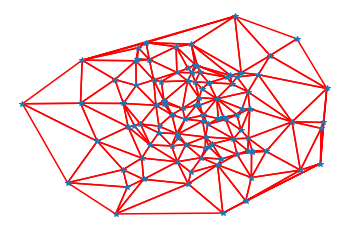

In [66]:
# 随机二维点集的狄洛克三角剖分
from matplotlib.tri import Triangulation

x, y = array(random.standard_normal((2, 100)))
triangles = Triangulation(x, y).triangles

figure()
for t in triangles:
    t_ext = [t[0], t[1], t[2], t[0]] # 将最后一个点加入到最后
    plot(x[t_ext], y[t_ext], 'r')
    
plot(x, y, '*')
axis('off')
show()

## 图像配准

*图像配准* 是对图像进行变换，使变换后的图像能够在常见的坐标系中对齐。为了能够进行图像对比和更精细的图像分析，图像配准是一步非常重要的操作。

以多个人脸图像配准为例。图像中的人脸并不都有相同的 **大小、位置和方向**。所以，我们实际上是寻找一个 **相似变换** （带有尺度变化的刚体变换），在对应点之间建立映射

对于每个点 $\mathbf x_i = [x_i, y_i]$，将其映射到目标位置 $[\hat x_i, \hat y_i]$ ：

$$  \begin{bmatrix} \hat x_i \\ \hat y_i \end{bmatrix} 
  = \begin{bmatrix} a & -b \\ b & a \end{bmatrix}
    \begin{bmatrix} x_i \\ y_i \end{bmatrix}
    + \begin{bmatrix} t_x \\ t_y \end{bmatrix}
$$

写成方程组的形式：

$$  \begin{bmatrix} \hat x_i \\ \hat y_i \end{bmatrix} 
  = \begin{bmatrix} x_i & -y_i & 1 & 0 \\ y_i & x_i & 0 & 1 \end{bmatrix}
    \begin{bmatrix} a \\ b \\ t_x \\ t_y \end{bmatrix}
$$

下面使用相似矩阵的参数化表示方式：

$$  \begin{bmatrix} a & -b \\ b & a \end{bmatrix} 
  = s \begin{bmatrix} \cos(\theta) & -\sin(\theta) \\
                      \sin(\theta) & \cos(\theta)
      \end{bmatrix}
  = s \mathbf R
$$

其中尺度 $ s = \sqrt {a^2 + b^2} $，旋转矩阵为 $\mathbf R$.

可以使用 *最小二乘解* 来计算相似变换中的参数。

### 最小二乘法（least squares method）

最小二乘法是一种数学优化方法，它基于均方误差最小化来进行模型求解。

在线性回归中，最小二乘法就是试图找到一条直线，使所有样本到直线上的欧式距离之和最小。

In [80]:
from tools import imregistration
reload(imregistration)

# 载入控制点的位置
xmlFileName = 'data/jkfaces.xml'
points = imregistration.read_points_from_xml(xmlFileName)
# 注册
imregistration.rigid_alignment(points, 'data/jkfaces')

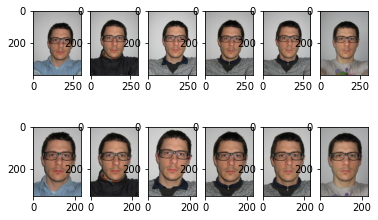

In [95]:
# 配准前后的图像对比
import os

names = sorted(points.keys())[:6]
fig, ax = plt.subplots(nrows=2, ncols=6)
for index, name in enumerate(names):
    ax[0][index].imshow(Image.open(os.path.join('data/jkfaces', name)))
    ax[1][index].imshow(Image.open(os.path.join('data/jkfaces', 'aligned', name)))

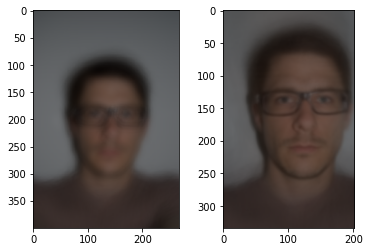

In [110]:
# 平均图像的比较：没有对齐操作，和经过三点刚体对齐操作
import tools.imtools
reload(tools.imtools)
from tools.imtools import get_imlist, compute_average

fig, ax = plt.subplots(nrows=1, ncols=2)

ax[0].imshow(Image.fromarray(compute_average(get_imlist('data/jkfaces'))))
ax[1].imshow(Image.fromarray(compute_average(get_imlist('data/jkfaces/aligned'))))

# 3. 创建全景图

在同一位置（即图像的照相机位置相同）拍摄的两幅或多幅图像是单应性相关的。我们经常使用该约束将很多图像缝补起来，拼成一个大的图像来创建全景图像。

## RANSAC（RANdom SAmple Consensus，随机一致性采样）

RANSAC 采用迭代的方法从带有噪声的数据中拟合出正确模型。给定一个模型，例如点集之间的单应性矩阵，RANSAC 的基本思想是，数据中包含正确的点和噪声点，而合理的模型应该能够在描述正确数据点的同时摒弃噪声点。

RANSAC 的标准例子：用一条直线拟合带有噪声数据的点集。简单的最小二乘在该例子中可能会失效，但是 RANSAC 能够挑出正确的点，然后获取能够正确拟合的曲线。

## 稳健的单应性矩阵估计


In [114]:
# 使用 SIFT 特征自动找到匹配对应
# SIFT 是具有很强稳健性的描述子，相对 Harris 角点产生更少的错误匹配。但是该方法仍然远非完美。

from tools import sift

featname = ['data/Univ{}.sift'.format(i) for i in range(1,6)]
imname = ['data/Univ{}.jpg'.format(i) for i in range(1,6)]
l = {}
d = {}
for i in range(5):
    sift.process_image(imname[i], featname[i])
    l[i], d[i] = sift.read_features_from_file(featname[i])

matches = {}
for i in range(4):
    matches[i] = sift.match(d[i+1], d[i])


下面使用 RANSAC 算法来求解单应性矩阵。

`RansacModel.fit(data)` 接受由 ransac.py 选择的 4 个对应点，拟合一个单应性矩阵。4 个点是计算单应性矩阵所需的最少数目。

`RansacModel.get_error(data, H)` 对每对对应点对使用该单应性矩阵，然后返回相应的平方距离之和，因此 RANSAC 算法能够判定哪些点对是正确的，哪些是错误的。在实际中，在距离上设置一个阈值来决定哪些单应性矩阵是合理的。

In [175]:
# 将 RANSAC 算法应用于对应点对上
reload(homography)

def convert_points(j):
    '''将匹配转换为齐次坐标点'''
    ndx = matches[j].nonzero()[0]
    fp = homography.make_homog(l[j+1][ndx, :2].T)
    ndx2 = [int(matches[j][i]) for i in ndx]
    tp = homography.make_homog(l[j][ndx2,:2].T)
    return fp, tp

# 估计单应性矩阵
model = homography.RansacModel()
# 在该例子中，图2是中心图像，也是我们希望将其他图像变成的图像。
# 所以图像0和1从右边扭曲，图像3和4从左边扭曲。
fp, tp = convert_points(1)
H_12 = homography.H_from_ransac(fp, tp, model)[0] # im1 到 im2 的单应性矩阵
fp, tp = convert_points(0)
H_01 = homography.H_from_ransac(fp, tp, model)[0] # im0 到 im1 的单应性矩阵
fp, tp = convert_points(2) # 注意：点是反序的 TODO
H_32 = homography.H_from_ransac(fp, tp, model)[0] # im3 到 im2 的单应性矩阵
fp, tp = convert_points(1) # 注意：点是反序的
H_43 = homography.H_from_ransac(fp, tp, model)[0] # im4 到 im3 的单应性矩阵


## 拼接图像

使用 RANSAC 估计出图像间的单应性矩阵后，我们将所有的图像扭曲到一个公共的图像平面上。通常，公共平面为中心图像平面，否则需要进行大量变形。

一种方法是创建一个很大的图像，图像中全部填充0，使其和中心图像平行，然后将所有图像扭曲到上面。

In [178]:
reload(warp)

delta = 2000 # 用于填充和平移

im1 = array(Image.open(imname[1]))
im2 = array(Image.open(imname[2]))
im_12 = warp.panorama(H_12, im1, im2, delta, delta)

im1 = array(Image.open(imname[0]))
im_02 = warp.panorama(dot(H_12, H_01), im1, im_12, delta, 2*delta)

im1 = array(Image.open(imname[3]))
im_32 = warp.panorama(H_32, im1, im_02, delta, delta)

im1 = array(Image.open(imname[4]))
im_42 = warp.panorama(dot(H_32, H_43), im1, im_32, delta, 2*delta)

warp - right
warp - right
warp - right
warp - right


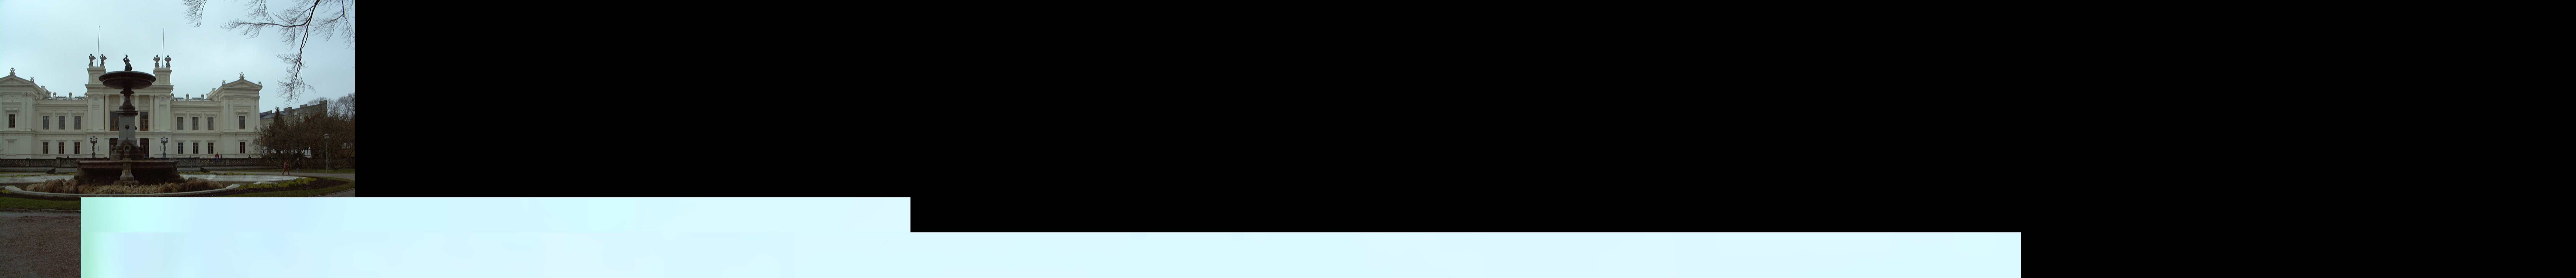

In [207]:
Image.fromarray(uint8(im_42))

拼接图中，由于图像曝光不同，在单个图像的边界上存在边缘效应。商业的创建全景图像软件里有额外的操作来对强度进行归一化，并对平移进行平滑场景转换，以使得结果看上去更好。